In [ ]:
import tensorflow as tf
import keras
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pandas import read_csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.utils import class_weight
import math
import gc
import glob
import os

# Downloading Base Model and Files

In [ ]:
if(os.path.exists('/content/DeepPicar-v3/')):
  os.system("rm -rf "+"/content/DeepPicar-v3/")
!git clone https://github.com/CSL-KU/DeepPicar-v3.git

Cloning into 'DeepPicar-v3'...
remote: Enumerating objects: 27632, done.
remote: Counting objects: 100% (27632/27632), done.
remote: Compressing objects: 100% (20237/20237), done.
remote: Total 27632 (delta 4279), reused 27628 (delta 4278), pack-reused 0
Receiving objects: 100% (27632/27632), 233.39 MiB | 17.56 MiB/s, done.
Resolving deltas: 100% (4279/4279), done.


In [ ]:
!cp -r '/content/drive/MyDrive/models' '/content/DeepPicar-v3/'
# The model that is already trained. Took it from one of the Picars

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/models/Deeppicar-ori.hdf5')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 66, 200, 3)        228       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 98, 3)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 98, 24)        1824      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 47, 24)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 5, 22, 36)        0

In [ ]:
print("Number of layers in the base model: ", len(model.layers))

Number of layers in the base model:  16


# Made all functions

In [ ]:
img_width = 200
img_height = 66
img_channels = 3

In [ ]:
# Helper functions for evaluating model accuracy
def rad2deg(rad):
  return 180.0 * rad / math.pi
def get_action(angle_rad):
  degree = rad2deg(angle_rad)
  lim = 10 # We found this value to be best experimentally
  if degree < lim and degree > -lim:
    return "center"
  elif degree >= lim:
    return "right"
  elif degree <-lim:
    return "left"

In [ ]:
def data_prep(dataset_dir):
  # Train/test data lists
  imgs = []
  vals = []

  for vid_file_path in glob.iglob(f'{dataset_dir}/*.avi'):
      csv_file_path = vid_file_path.replace('video', 'key').replace('avi', 'csv')
      print(vid_file_path, csv_file_path)

      vid = cv2.VideoCapture(vid_file_path)
      ret,img = vid.read()
      while(ret):
          img =  img[img.shape[0]//2:]

          # Convert to grayscale and read channel dimension
          if img_channels == 1:
              img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
              img = cv2.resize(img, (img_width, img_height))
              img = np.reshape(img, (img_height, img_width, img_channels))
          # For RGB, just need to resize image
          else:
              img = cv2.resize(img, (img_width, img_height))
          img = img / 255.
          imgs.append(img)
          ret,img = vid.read()
      df = read_csv(csv_file_path)
      temp = np.asarray(df["wheel"].values)
      vals.extend(temp)
      print(len(imgs), len(vals))

  # Convert lists to numpy arrays and ensure they are of equal length
  imgs = np.asarray(imgs)  # input images
  vals = np.asarray(vals)  # steering angles
  assert len(imgs) == len(vals)
  print("Loaded {} samples".format(len(imgs)))
  return imgs, vals


In [ ]:
def data_split(imgs, vals):
  x_train, x_test, y_train, y_test = train_test_split(imgs, vals, test_size=0.35, stratify=vals)
  print(f'x_train: {len(x_train)}')
  print(f'x_test: {len(x_test)}')
  return x_train, x_test, y_train, y_test

In [ ]:
import requests
import os
import zipfile
import shutil
from sklearn.metrics import confusion_matrix

def get_accuracy(model, x_test, y_test):
  print('For current dataset:')
  pred_angle = model.predict(x_test)
  pred = np.array(list(map(get_action, pred_angle)))
  ground = np.array(list(map(get_action, y_test)))
  curr_acc = np.mean(pred == ground)
  cf = classification_report(ground, pred)

  print()
  print('------>Accuracy is %.2f<------' % curr_acc)
  print()
  print('Balanced Accuracy is %.2f' %balanced_accuracy_score(ground, pred))
  print(cf)
  print(confusion_matrix(ground, pred))

  return curr_acc,cf


In [ ]:
def save_model(model, model_file, dl):
  # Save both the Keras and TFLite models
  print("Model Save")
  model.save(f'/content/DeepPicar-v3/models/Deeppicar-ori.hdf5')

  print("TFLite Model")
  converter = tf.lite.TFLiteConverter.from_keras_model(model)
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  # converter.target_spec.supported_types = [tf.float16]

  quantized_tflite_model = converter.convert()

  with open(model_file+".tflite", 'wb') as f:
      f.write(quantized_tflite_model)

  print (model_file+".tflite is saved. copy this file to the robot")

  RunningInCOLAB = 'google.colab' in str(get_ipython())
  if RunningInCOLAB and dl:
      from google.colab import files
      files.download(model_file+".tflite")
      files.download('/content/DeepPicar-v3/models/Deeppicar-ori.hdf5')

Previously:

Epochs = 20

Batch_size = 64

Adam Optimizer = 0.0003


Functions:
- rad2deg(rad) : return deg
- get_action(angle_rad) : return left, right, center
- data_prep(dataset_dir) :  return imgs, vals
- data_split(imgs, vals) : return x_train, x_test, y_train, y_test
- model_fit(model, x_train, y_train, x_test, y_test) : return history
- get_accuracy(model, x_test, y_test) : return void
- save_model(model_file): returns void but downloads .hdf5 and tflite


Now:


# Retrain The Model on my Driving

In [ ]:
data_dir = '/content/drive/MyDrive/Dataset 1'
imgs, vals = data_prep(data_dir)
x_train,x_test,y_train,y_test = data_split(imgs, vals)

/content/drive/MyDrive/Dataset 1/out-video.avi /content/drive/MyDrive/Dataset 1/out-key.csv
1217 1217
Loaded 1217 samples
x_train: 791
x_test: 426


In [ ]:
model_name = "model_large"
model_file = "models/{}-{}x{}x{}".format(model_name[6:], img_width, img_height, img_channels)
print ("Model compile")
lr = 5e-5
optimizer = tf.keras.optimizers.Adam(lr)

if os.path.isfile(model_file+".h5"):
    print('True')
    model = tf.keras.models.load_model(model_file+".h5")
    optimizer = optimizer=tf.keras.optimizers.Adam(lr)

model.compile(optimizer=optimizer,loss='huber')

Model compile


Model fit
Epoch 1/20
13/13 [==============================] - 10s 68ms/step - loss: 0.2458 - val_loss: 0.0324
Epoch 2/20
13/13 [==============================] - 0s 22ms/step - loss: 0.1736 - val_loss: 0.0316
Epoch 3/20
13/13 [==============================] - 0s 22ms/step - loss: 0.1654 - val_loss: 0.0307
Epoch 4/20
13/13 [==============================] - 0s 23ms/step - loss: 0.1591 - val_loss: 0.0295
Epoch 5/20
13/13 [==============================] - 0s 22ms/step - loss: 0.1508 - val_loss: 0.0280
Epoch 6/20
13/13 [==============================] - 0s 22ms/step - loss: 0.1396 - val_loss: 0.0261
Epoch 7/20
13/13 [==============================] - 0s 22ms/step - loss: 0.1294 - val_loss: 0.0245
Epoch 8/20
13/13 [==============================] - 0s 22ms/step - loss: 0.1230 - val_loss: 0.0236
Epoch 9/20
13/13 [==============================] - 0s 22ms/step - loss: 0.1206 - val_loss: 0.0233
Epoch 10/20
13/13 [==============================] - 0s 21ms/step - loss: 0.1178 - val_loss: 0.023

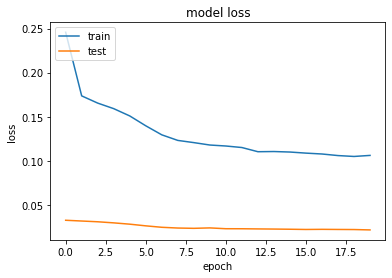


--- 22 seconds ---


In [ ]:
#Training the model

import time
start_time = time.time()
print ("Model fit")

class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(y_train), y = y_train)
class_weights = {i:class_weights[i] for i in range(len(class_weights))}

# This trains the model
history = model.fit(x_train, y_train, batch_size=64,
                    epochs=20, validation_data=(x_test, y_test), class_weight=class_weights)
# Plot training and validation losses
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


print(f'\n--- {round(time.time() - start_time)} seconds ---')

In [ ]:
base_model_p, base_model_p_cf = get_accuracy(model, x_test, y_test)

For current dataset:
14/14 [==============================] - 0s 14ms/step

------>Accuracy is 0.75<------

Balanced Accuracy is 0.62
              precision    recall  f1-score   support

      center       0.83      0.82      0.83       308
        left       0.52      0.42      0.47        26
       right       0.55      0.61      0.58        92

    accuracy                           0.75       426
   macro avg       0.64      0.62      0.63       426
weighted avg       0.75      0.75      0.75       426

[[253  10  45]
 [ 15  11   0]
 [ 36   0  56]]


In [ ]:
model_name = "model_large"
model_file = "/content/DeepPicar-v3/models/{}-{}x{}x{}".format(model_name[6:], img_width, img_height, img_channels)
save_model(model, model_file, 1)

Model Save
TFLite Model


/content/DeepPicar-v3/models/large-200x66x3.tflite is saved. copy this file to the robot


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Data Perp For Transfer Learn

In [ ]:
data_dir = '/content/drive/MyDrive/Dataset 2'
imgs, vals = data_prep(data_dir)
# New Data in dim lights. Where car cannot follow the path properly

/content/drive/MyDrive/Dataset 2/out-video.avi /content/drive/MyDrive/Dataset 2/out-key.csv
737 737
Loaded 737 samples


#Split

In [ ]:
x_train,x_test,y_train,y_test = data_split(imgs, vals)

x_train: 479
x_test: 258


In [ ]:
base_model_c, base_model_c_cf = get_accuracy(model, x_test, y_test)

For current dataset:
9/9 [==============================] - 0s 20ms/step

------>Accuracy is 0.75<------

Balanced Accuracy is 0.48
              precision    recall  f1-score   support

      center       0.79      0.87      0.83       178
        left       0.00      0.00      0.00        13
       right       0.64      0.57      0.60        67

    accuracy                           0.75       258
   macro avg       0.48      0.48      0.48       258
weighted avg       0.71      0.75      0.73       258

[[155   2  21]
 [ 13   0   0]
 [ 29   0  38]]


# Finally Trying Transfer learning on new Datset

In [ ]:
model_name = "model_large"
model_file = "models/{}-{}x{}x{}".format(model_name[6:], img_width, img_height, img_channels)
print ("Model compile")
lr = 3e-4
optimizer = tf.keras.optimizers.Adam(lr)

if os.path.isfile(model_file+".h5"):
    print('True')
    model = tf.keras.models.load_model(model_file+".h5")
    optimizer = optimizer=tf.keras.optimizers.Adam(5e-5)

model.compile(optimizer=optimizer,loss='huber')

Model compile


In [ ]:
print('---->Layers Trying to train: <----\n')
model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(model.layers), model.trainable)

for layer in model.layers[:]:
  layer.trainable = False
#for layer in model.layers[2:13]:
model.layers[2].trainable = True
model.layers[14].trainable = True

i = 0
for layer in model.layers:
  print(f'{i}. Layer {layer.name}: {layer.trainable}')
  i+=1
print('\n\n')

print('Traianble Layers')
i = 0
for layer in model.layers:
  if layer.trainable:
      print(f'{i}. Layer {layer.name}: {layer.trainable}')
  i+=1
print('\n\n')

model.summary()

---->Layers Trying to train: <----

Number of layers in the base model:  16 True
0. Layer conv2d: False
1. Layer max_pooling2d: False
2. Layer conv2d_1: True
3. Layer max_pooling2d_1: False
4. Layer conv2d_2: False
5. Layer max_pooling2d_2: False
6. Layer conv2d_3: False
7. Layer max_pooling2d_3: False
8. Layer conv2d_4: False
9. Layer max_pooling2d_4: False
10. Layer conv2d_5: False
11. Layer flatten: False
12. Layer dense: False
13. Layer dense_1: False
14. Layer dense_2: True
15. Layer dense_3: False



Traianble Layers
2. Layer conv2d_1: True
14. Layer dense_2: True



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 66, 200, 3)        228       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 98, 3)        0         
 )                                                               
    

Model fit
Epoch 1/5
8/8 [==============================] - 1s 91ms/step - loss: 0.1860 - val_loss: 0.0267
Epoch 2/5
8/8 [==============================] - 0s 23ms/step - loss: 0.1562 - val_loss: 0.0208
Epoch 3/5
8/8 [==============================] - 0s 23ms/step - loss: 0.1554 - val_loss: 0.0211
Epoch 4/5
8/8 [==============================] - 0s 24ms/step - loss: 0.1454 - val_loss: 0.0197
Epoch 5/5
8/8 [==============================] - 0s 22ms/step - loss: 0.1407 - val_loss: 0.0186
dict_keys(['loss', 'val_loss'])


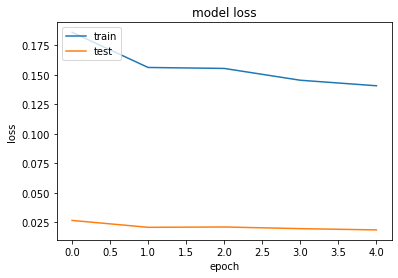


--- 2 seconds ---


In [ ]:
#Training the model
ep = 5
import time
start_time = time.time()
print ("Model fit")

class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(y_train), y = y_train)
class_weights = {i:class_weights[i] for i in range(len(class_weights))}

# This trains the model
history = model.fit(x_train, y_train, batch_size=64,
                    epochs=ep, validation_data=(x_test, y_test), class_weight=class_weights)
# Plot training and validation losses
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


print(f'\n--- {round(time.time() - start_time)} seconds ---')

In [ ]:
model_c, model_c_cf = get_accuracy(model, x_test, y_test)

For current dataset:
9/9 [==============================] - 0s 5ms/step

------>Accuracy is 0.83<------

Balanced Accuracy is 0.79
              precision    recall  f1-score   support

      center       0.94      0.80      0.87       178
        left       0.53      0.62      0.57        13
       right       0.69      0.94      0.80        67

    accuracy                           0.83       258
   macro avg       0.72      0.79      0.75       258
weighted avg       0.86      0.83      0.83       258

[[143   7  28]
 [  5   8   0]
 [  4   0  63]]


In [ ]:
data_dir = '/content/drive/MyDrive/Dataset 1'
imgs, vals = data_prep(data_dir)
x_train,x_test,y_train,y_test = data_split(imgs, vals)
model_p, model_p_cf = get_accuracy(model, x_test, y_test)

/content/drive/MyDrive/Dataset 1/out-video.avi /content/drive/MyDrive/Dataset 1/out-key.csv
1217 1217
Loaded 1217 samples
x_train: 791
x_test: 426
For current dataset:
14/14 [==============================] - 0s 4ms/step

------>Accuracy is 0.71<------

Balanced Accuracy is 0.64
              precision    recall  f1-score   support

      center       0.85      0.73      0.79       308
        left       0.36      0.46      0.41        26
       right       0.52      0.74      0.61        92

    accuracy                           0.71       426
   macro avg       0.58      0.64      0.60       426
weighted avg       0.75      0.71      0.72       426

[[224  21  63]
 [ 14  12   0]
 [ 24   0  68]]


# Comparision

In [ ]:
from tabulate import tabulate
data = [[base_model_p_cf, model_p_cf],
        [f'Accuracy: {base_model_p: .2%}', f'Accuracy: {model_p: .2%}']]
col_names = ["Base Model", "Transfer Learned Model"]
print("Dataset 1 - Original Light")
print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))


data = [[base_model_c_cf, model_c_cf],
         [f'Accuracy: {base_model_c: .2%}', f'Accuracy: {model_c: .2%}']]
col_names = ["Base Model", "Transfer Learned Model"]
print("Dataset 2 - Dim Light")
print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))

Dataset 1 - Original Light
╒═══════════════════════════════════════════════════════╤═══════════════════════════════════════════════════════╕
│ Base Model                                            │ Transfer Learned Model                                │
╞═══════════════════════════════════════════════════════╪═══════════════════════════════════════════════════════╡
│ precision    recall  f1-score   support               │ precision    recall  f1-score   support               │
│                                                       │                                                       │
│       center       0.83      0.82      0.83       308 │       center       0.85      0.73      0.79       308 │
│         left       0.52      0.42      0.47        26 │         left       0.36      0.46      0.41        26 │
│        right       0.55      0.61      0.58        92 │        right       0.52      0.74      0.61        92 │
│                                                       │    

In [ ]:
[base_model_p, model_p]

[0.7511737089201878, 0.7136150234741784]

In [ ]:
[base_model_c, model_c]

[0.748062015503876, 0.8294573643410853]

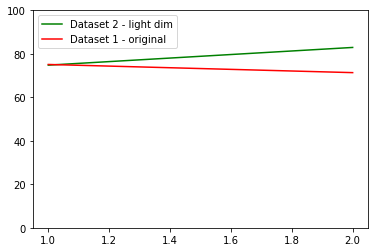

In [ ]:
plt.plot([1, 2],[base_model_c*100, model_c*100], label = 'Dataset 2 - light dim', color = 'green')
plt.plot([1,2],[base_model_p*100, model_p*100], label = 'Dataset 1 - original',color='red')
plt.ylim(0,100)
plt.legend()
plt.show()

In [ ]:
model_name = "model_large"
model_file = "/content/DeepPicar-v3/models/{}-{}x{}x{}".format(model_name[6:], img_width, img_height, img_channels)
save_model(model, model_file, 1)

Model Save
TFLite Model


/content/DeepPicar-v3/models/large-200x66x3.tflite is saved. copy this file to the robot


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Notes

## Test 1:
```
Epoch = 10
Layer conv2d: True
Layer max_pooling2d: True
Layer dense_3: True
lr = 3e-4
Time = --- 427 seconds ---
```
Observation:
- accuracy drops

# Test 2: ---> Best model so far practically <---
```
Epoch = 5
Traianble Layers
2. Layer conv2d_1: True
14. Layer dense_2: True
lr = 3e-4
--- 103 seconds ---
```
Observation:
- Full Light: 3 out 5 times fails to complete the path
- Dim Light: 3 out 5 times fails to complete the path
- The base dataset on which the model is trained is very important. It influnece the transfer model.
- Since this is practically good model, some inferences drawn are:
  - The accuracies of both datset must coincide
  - none of the datset accuacies must drop - otherwise model is bond to fail
  - Training the last layer will overfit the model: But stil experiment it with combination of layers
  - Training the layers with less parameters help - Which I knew but was training the top layers initally. I decided to move with middle layer/hidden layers but withless params.
  - Even though 2 epoch gets you less accuarcy but need to train more for better model.
  - At the same time you need to keep epoch less otherwise it will corrupt the base model weights

